# Project 4: TIC-TAC-TOE with RL

In this project, you will delve into the world of reinforcement learning by developing an advanced version of the classic Tic Tac Toe game. You will be responsible for coding the game's logic and employing a variety of reinforcement learning strategies, including Monte Carlo method, Q-learning, Deep Q-Network (DQN), and Double Deep Q-Network (DDQN). Your goal will be to train models that master the game. You will construct the game environment, apply cutting-edge reinforcement learning techniques, and assess how well your models perform.
This hands-on experience is designed to equip you with a solid understanding of reinforcement learning fundamentals and its real-world applications in creating intelligent systems. By the end of the project, you will have practical skills in training AI agents to tackle complex challenges.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
my_path="/content/drive/MyDrive/"

## Install W&B


In [4]:
!pip -q install wandb

In [5]:
\import wandb
wandb.login()  # will prompt for API key

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tomersagi (tomersagi-projects) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Required Libraries

In [6]:
import pickle
import numpy as np
import random
from tqdm import tqdm
from collections import deque
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Conv1D
from keras.models import load_model

# Game Entities - Tic Tac Toe Environment
This TicTacToe class defines the structure and logic for a customizable Tic Tac Toe game. The class initializes with an optional size parameter (defaulting to 3x3), sets up an empty game board, and tracks the current winner, which is initially set to None. Key methods include print_board to display the current state of the board, available_moves to list possible moves, make_move to update the board with a player's move, and winner to check if a move results in a win. The class also includes utility functions like empty_squares and num_empty_squares to assess the board's status.

***no modifications are required from participants. The class is ready to be used directly in the exercise.***

In [7]:
class TicTacToe:
    def __init__(self, size=3):
        # Initialize the Tic Tac Toe board with given size
        self.size = size
        # Create an empty board using a list
        self.board = [' ' for _ in range(size*size)]
        # Current winner is set to None initially
        self.current_winner = None

    def print_board(self):
        # Print the Tic Tac Toe board
        for row in [self.board[i * self.size:(i + 1) * self.size] for i in range(self.size)]:
            print('| ' + ' | '.join(row) + ' |')

    @staticmethod
    def print_board_nums(size):
        # Print the board with numbers indicating the positions
        number_board = [[str(i) for i in range(j * size, (j + 1) * size)] for j in range(size)]
        for row in number_board:
            print('| ' + ' | '.join(row) + ' |')

    def available_moves(self):
        # Return a list of available moves
        return [i for i, spot in enumerate(self.board) if spot == ' ']

    def total_moves(self):
        # Return a list of all moves
        return [i for i, _ in enumerate(self.board)]

    def empty_squares(self):
        # Check if there are empty squares on the board
        return ' ' in self.board

    def num_empty_squares(self):
        # Return the number of empty squares
        return self.board.count(' ')

    def make_move(self, square, letter):
        # Make a move on the board
        if self.board[square] == ' ':
            self.board[square] = letter
            # Check if the current move leads to a win
            if self.winner(square, letter):
                self.current_winner = letter
            return self.board
        else:
            # Print message if the square is invalid
            print("INVALID SQUARE: ",square)

    def winner(self, square, letter):
        # Check if there is a winner after the current move
        row_ind = square // self.size
        row = self.board[row_ind * self.size:(row_ind + 1) * self.size]
        if all([spot == letter for spot in row]):
            return True
        col_ind = square % self.size
        column = [self.board[col_ind + i * self.size] for i in range(self.size)]
        if all([spot == letter for spot in column]):
            return True
        if square % (self.size + 1) == 0:  # diagonal 1
            diagonal1 = [self.board[i] for i in range(0, self.size * self.size, self.size + 1)]
            if all([spot == letter for spot in diagonal1]):
                return True
        if square % (self.size - 1) == 0 and square != 0 and square != self.size * (self.size - 1):  # diagonal 2
            diagonal2 = [self.board[i] for i in range(self.size - 1, self.size * self.size - 1, self.size - 1)]
            if all([spot == letter for spot in diagonal2]):
                return True
        return False

# 1. Trainer - Monte Carlo

The following TicTacToe MonteCarlo class implements the Monte Carlo learning method to optimize the game strategy for Tic Tac Toe. It is initialized with parameters for the game size, learning rate, discount factor, and exploration rate (epsilon). The class manages a Q-table for storing the value estimates for each state-action pair, and employs an epsilon-greedy strategy for action selection to balance between exploration and exploitation.

Key functionalities include:

* state_to_str(state): Converts the game state to a string key for Q-table referencing.
* select_action(state, moves): Determines the next action using an epsilon-greedy approach. It randomly selects an action with a probability of epsilon for exploration; otherwise, it chooses the action with the highest estimated value from the Q-table for exploitation.
* update_q_table(episode, reward): Updates the Q-table based on the total reward obtained at the end of an episode. This method employs the Monte Carlo approach by updating the Q-values for all unique state-action pairs visited in an episode, applying a learning rate to adjust values towards the observed total reward.
* train(episodes): Conducts multiple episodes of game simulations to train the model. During each episode, the game is played until there are no more moves or a player wins. Rewards are assigned based on the game outcome, and the Q-table is updated with the cumulative reward of the episode.

***no modifications are required from participants. The class is ready to be used directly in the exercise.***

In [19]:
class TicTacToeMonteCarlo:
    def __init__(self, size=3, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.size = size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = {}
        self.game = TicTacToe(size)
        self.player_1 = 'X'
        self.player_2 = 'O'

        # Epsilon evaluation - exploration vs exploitation
        self.exploration_counts = []
        self.exploitation_counts = []

        # Convergance evaluation
        self.training_rewards = []
        self.q_table_sizes = [] # -- Policy Growth (size of q_table indicates policy growth)
        self.entropy_history = []

    def state_to_str(self, state):
        return ''.join(state)

    def select_action(self, state, moves):
        state_str = self.state_to_str(state)

        explore = np.random.rand() < self.epsilon

        if explore:
            action = random.choice(moves)
            self._current_explore += 1
        else:
            if state_str not in self.q_table:
                action = random.choice(moves)
                self._current_explore += 1
            else:
                filtered_items = [(key, value) for key, value in self.q_table[state_str].items() if key in moves]
                action = max(filtered_items, key=lambda item: item[1])[0]
                self._current_exploit += 1

        return action

    def update_q_table(self, episode, reward):
        visited_states = set()
        for state, action in episode:
            state_str = self.state_to_str(state)
            if state_str not in visited_states:
                if state_str not in self.q_table:
                    self.q_table[state_str] = {}
                if action not in self.q_table[state_str]:
                    self.q_table[state_str][action] = 0
                self.q_table[state_str][action] += self.learning_rate * (reward - self.q_table[state_str][action])
                visited_states.add(state_str)

    def train(self, episodes):
        for ep in tqdm(range(episodes)):
            self.game = TicTacToe(self.size)
            current_state = self.game.board.copy()
            episode = []
            total_reward = 0
            letter = self.player_1
            game_over = False

            self._current_explore = 0
            self._current_exploit = 0
            step_rewards = [] # Collect step_rewards to post-episode update the rewards with the discountsw applied

            while self.game.empty_squares():
                moves = self.game.available_moves()

                if letter == self.player_2:
                    square = random.choice(moves)
                else:
                    square = self.select_action(current_state, moves)

                episode.append((current_state, square))
                next_state = self.game.make_move(square, letter)

                if self.game.current_winner:
                    reward = 1 if letter == self.player_1 else -1.5
                    game_over = True
                    break
                else:
                    reward = 0.0001

                step_rewards.append(reward) # -- Store the rewards in the 'discount' buffer
                total_reward += reward
                current_state = next_state.copy()
                letter = self.player_2 if letter == self.player_1 else self.player_1

            if not game_over:
                reward = 0.5
            total_reward += reward

            # -- Original update with the total_rewards_flat (without the discount)
            # self.update_q_table(episode, total_reward)

            # -- Apply the discount to the episode (Compute discounted return)
            G = 0.0
            for r in reversed(step_rewards):
                G = r + self.discount_factor * G

            self.update_q_table(episode, G)

            # === Store metrics ===
            self.training_rewards.append(total_reward)
            self.q_table_sizes.append(len(self.q_table))
            self.entropy_history.append(policy_entropy(self.q_table))

            # === Early stopping check ===
            if ep > 2000:
                if (reward_plateau_detected(self.training_rewards) and
                    qtable_converged(self.q_table_sizes) and
                    entropy_stable(self.entropy_history)):

                    print(f"\nConverged at episode {ep}")
                    break

            self.exploration_counts.append(self._current_explore)
            self.exploitation_counts.append(self._current_exploit)

            # -- Apply the discount to the episode (Compute discounted return)
            G = 0.0
            for r in reversed(step_rewards):
                G = r + self.discount_factor * G

            self.update_q_table(episode, G)

            # === Log metrics ===
            if ep % 100 == 0:
              wandb.log({
                  "episode": ep,
                  "reward": total_reward,                  # or discounted G if you change it
                  "q_table_size": len(self.q_table),
                  "policy_entropy": self.entropy_history[-1],
                  "explore_ratio": (self.exploration_counts[-1] /
                                    max(1, self.exploration_counts[-1] + self.exploitation_counts[-1])),
                  "exploit_ratio": (self.exploitation_counts[-1] /
                                    max(1, self.exploration_counts[-1] + self.exploitation_counts[-1])),
              }, step=ep)

## Utility functions

In [6]:
def reward_plateau_detected(rewards, W=500, K=1000, delta=0.001):
    rewards = np.array(rewards)
    if len(rewards) < W + K:
        return False
    ma = np.convolve(rewards, np.ones(W)/W, mode='valid')
    return abs(ma[-1] - ma[-K]) < delta


def qtable_converged(q_sizes, K=1000, epsilon=0.01):
    if len(q_sizes) < K:
        return False
    growth_rate = (q_sizes[-1] - q_sizes[-K]) / K
    return growth_rate < epsilon


def policy_entropy(q_table, sample_states=100):
    if not q_table:
        return 0
    entropies = []
    states = list(q_table.keys())
    sample = random.sample(states, min(len(states), sample_states))

    for s in sample:
        actions = q_table[s]
        values = np.array(list(actions.values()))
        probs = np.exp(values) / np.sum(np.exp(values))
        H = -np.sum(probs * np.log(probs + 1e-9))
        entropies.append(H)

    return np.mean(entropies)


def entropy_stable(entropies, K=500, eta=0.001):
    if len(entropies) < K:
        return False
    return abs(entropies[-1] - entropies[-K]) < eta


## Training

### Hyperparameters

In [44]:
## -- Define hyperparameters
size = 3

# Experiments
# * 1e-4 --> yielded higher wins, but longer to converge, with largest q-table size
learning_rate = 1e-4 # 1e-3 yielded

# Experimnets
# * 0.05 -->
discount_factor = 0.05

epsilon = 0.1 # Should also be 1e-1
episodes = 100000

### Log W&B

In [45]:
run = wandb.init(
    project="tictactoe-mc",
    config={
        "size": size,
        "learning_rate": learning_rate,
        "discount_factor": discount_factor,
        "epsilon": epsilon,
        "episodes": episodes,
        "ma_window": 500,
    }
)
config = run.config


episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
exploit_ratio,██▁▇██▆███▃▅▅█▇▆█▇▆████▅▇▆▆▆█▆▆█▆█▆██▇██
explore_ratio,▁▁█▃▃▁▃▁▁▃▁▃▁▄▅▁▁▁▁▁▁▅▁▁▁▁▁▃▄▁▁▄▄▅▁▅▅▁▄▁
policy_entropy,▂▁▄▄▃▄▆▅▄▆▅▃▇▄▇▆▆▆▄▅▆▅▅▆▅▅▇▄▆▇▅▆▅▆█▇▅█▇▅
q_table_size,▁▂▃▃▃▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████████
reward,█▇█▁████████▇█▁▁██▁█▇███▇▇█▇████▁▁█▁███▁
episode,99900
exploit_ratio,1
explore_ratio,0
policy_entropy,0.6937
q_table_size,4024


In [46]:
# -- Train
mc = TicTacToeMonteCarlo(size=size, learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon)
mc.train(episodes)

 53%|█████▎    | 53438/100000 [04:53<04:15, 182.34it/s]


Converged at episode 53438


## 📊 Evaluation Plots — Definitions & Formulas

### 🧪 Learning Rate — Cumulative Reward

**Description:**  
Shows how different learning rates affect convergence speed and training stability.

$$
R_t = \sum_{k=1}^{T_t} r_k
$$

Where  
$R_t$ = cumulative reward of episode $t$  
$r_k$ = reward at step $k$

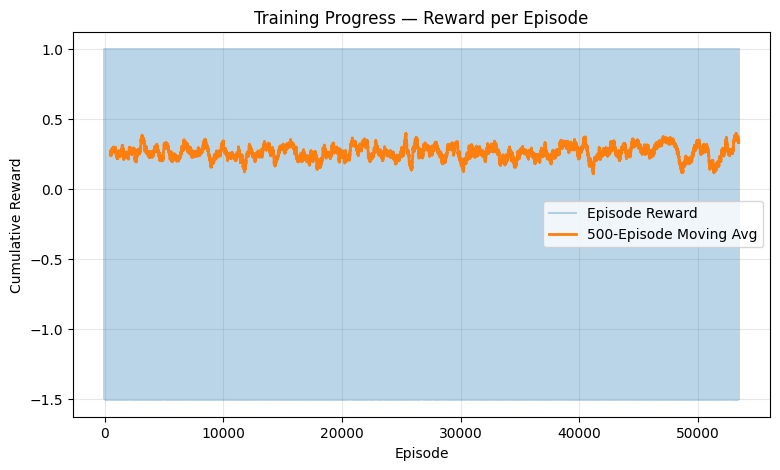

In [47]:
import numpy as np
import matplotlib.pyplot as plt

rewards = np.array(mc.training_rewards)

window = 500
moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')

fig = plt.figure(figsize=(9,5))
plt.plot(rewards, alpha=0.3, label='Episode Reward')
plt.plot(range(window-1, len(rewards)), moving_avg, linewidth=2, label=f'{window}-Episode Moving Avg')

plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Training Progress — Reward per Episode')
plt.legend()
plt.grid(alpha=0.3)

# Log figure to W&B
wandb.log({"reward_convergence_plot": wandb.Image(fig)})

plt.show()
plt.close(fig)

### 🧱 Policy Growth — Q-Table Size

**Description:**  
Tracks the growth of the agent’s learned knowledge by measuring the number of distinct states stored in the Q-table.

$$
|Q_t| = \text{number of states in the Q-table at episode } t
$$

Growth rate:

$$
G_t = \frac{|Q_t| - |Q_{t-K}|}{K}
$$

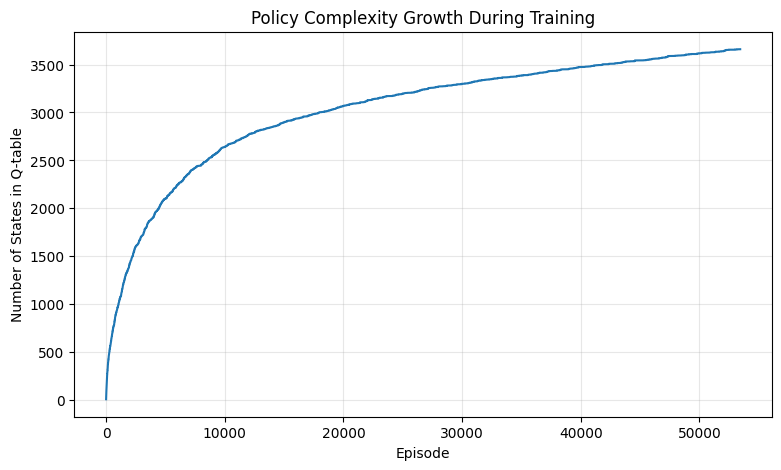

In [48]:
plt.figure(figsize=(9,5))
plt.plot(mc.q_table_sizes)
plt.xlabel('Episode')
plt.ylabel('Number of States in Q-table')
plt.title('Policy Complexity Growth During Training')
plt.grid(alpha=0.3)
plt.show()

### 🧭 Epsilon Effectiveness

**Description:**  
Measures the balance between exploration and exploitation.

$$
\text{Exploration Ratio}_t = \frac{E_t}{E_t + X_t}
$$

$$
\text{Exploitation Ratio}_t = \frac{X_t}{E_t + X_t}
$$

Where  
$E_t$ = number of exploratory actions  
$X_t$ = number of exploitative actions

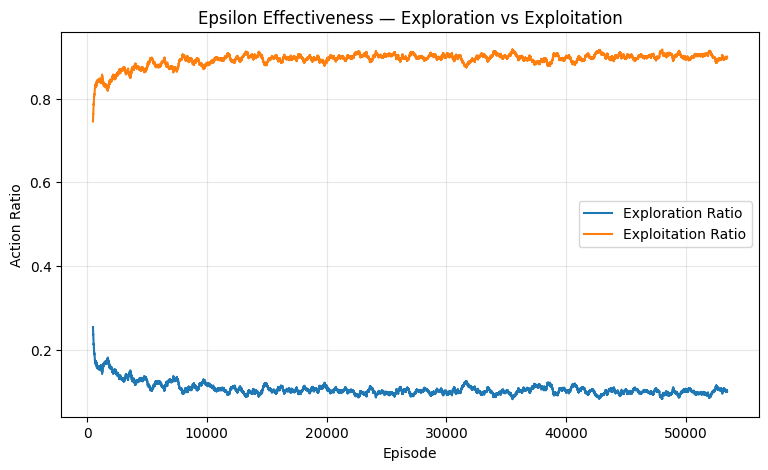

In [49]:
explore = np.array(mc.exploration_counts)
exploit = np.array(mc.exploitation_counts)

total_actions = explore + exploit
explore_ratio = explore / total_actions
exploit_ratio = exploit / total_actions

window = 500
smooth_explore = np.convolve(explore_ratio, np.ones(window)/window, mode='valid')
smooth_exploit = np.convolve(exploit_ratio, np.ones(window)/window, mode='valid')

plt.figure(figsize=(9,5))
plt.plot(range(window-1, len(explore_ratio)), smooth_explore, label='Exploration Ratio')
plt.plot(range(window-1, len(exploit_ratio)), smooth_exploit, label='Exploitation Ratio')

plt.xlabel('Episode')
plt.ylabel('Action Ratio')
plt.title('Epsilon Effectiveness — Exploration vs Exploitation')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### 🟠 Reward Convergence

**Description:**  
Detects convergence when the moving average of cumulative reward stabilizes.

$$
\bar{R}_t = \frac{1}{W} \sum_{i=t}^{t+W-1} R_i
$$

Convergence condition:

$$
\left| \bar{R}_t - \bar{R}_{t-K} \right| < \delta
$$

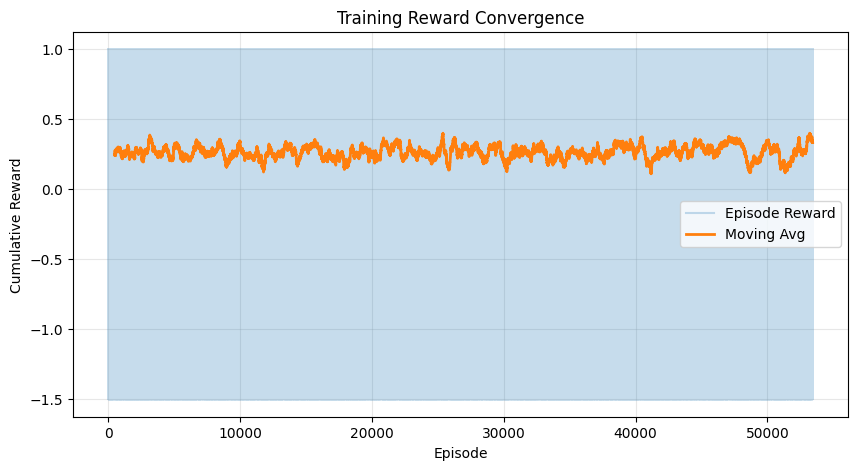

In [50]:
rewards = np.array(mc.training_rewards)

window = 500
ma = np.convolve(rewards, np.ones(window)/window, mode='valid')

# Correct x-axis
x_ma = np.arange(window - 1, window - 1 + len(ma))

plt.figure(figsize=(10,5))
plt.plot(rewards, alpha=0.25, label='Episode Reward')
plt.plot(x_ma, ma, linewidth=2, label='Moving Avg')

plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Training Reward Convergence')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### 🧱 Q-Table Growth Convergence

**Description:**  
Confirms structural convergence when new states stop being discovered.

$$
G_t = \frac{|Q_t| - |Q_{t-K}|}{K}
\quad \text{and convergence when } G_t < \epsilon
$$

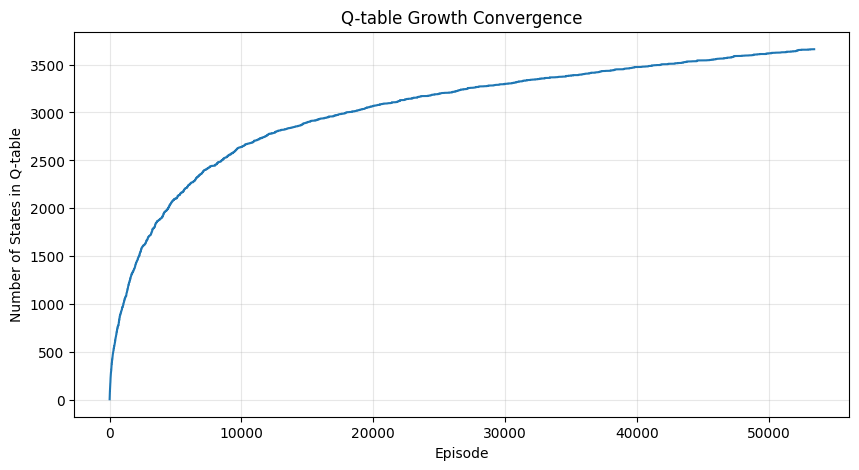

In [51]:
q_sizes = np.array(mc.q_table_sizes)

plt.figure(figsize=(10,5))
plt.plot(q_sizes)
plt.xlabel('Episode')
plt.ylabel('Number of States in Q-table')
plt.title('Q-table Growth Convergence')
plt.grid(alpha=0.3)
plt.show()


### 🎯 Policy Entropy — Detailed Explanation

The policy entropy measures how **uncertain** the agent is about which action to take in a given state.

It is defined as:

$$
H(\pi(s)) = - \sum_a p(a|s) \log p(a|s)
$$

#### 🧠 Meaning of Each Term

- $s$ — a game state (board configuration)  
- $a$ — a possible action (move)  
- $\pi$ — the agent’s policy (decision strategy)  
- $\pi(s)$ — the policy at state $s$  
- $p(a|s)$ — probability of choosing action $a$ in state $s$  
- $H(\pi(s))$ — entropy (uncertainty) of the policy at state $s$

#### 🧮 Interpretation

Entropy measures **how confident the agent is** in its decision:

- **High entropy:** many actions are equally likely → agent is uncertain  
- **Low entropy:** one action dominates → agent is confident  

#### 🔄 How Probabilities Are Obtained

The Q-table stores values, not probabilities.  
Therefore, Q-values are converted to probabilities using a softmax transformation:

$$
p(a|s) = \frac{e^{Q(s,a)}}{\sum_{a'} e^{Q(s,a')}}
$$

#### 🧭 Entropy During Learning

| Training Phase | Behavior | Entropy |
|---------------|---------|---------|
Early | Random & exploratory | High |
Learning | Improving strategy | Decreasing |
Converged | Stable optimal policy | Low & stable |

#### 🧪 Entropy-Based Convergence Condition

Behavioral convergence is detected when entropy stabilizes:

$$
\left| \bar{H}_t - \bar{H}_{t-K} \right| < \eta
$$

Where:

- $\bar{H}_t$ — mean entropy at episode $t$  
- $K$ — lookback window  
- $\eta$ — stability tolerance

When this condition holds, the agent’s **decision behavior has converged**.

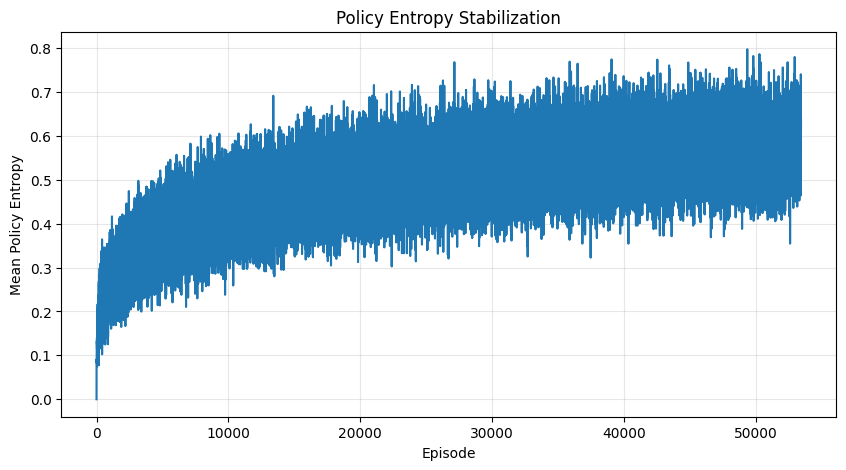

In [52]:
entropy = np.array(mc.entropy_history)

plt.figure(figsize=(10,5))
plt.plot(entropy)
plt.xlabel('Episode')
plt.ylabel('Mean Policy Entropy')
plt.title('Policy Entropy Stabilization')
plt.grid(alpha=0.3)
plt.show()


#### Entropy Stability Band Plot

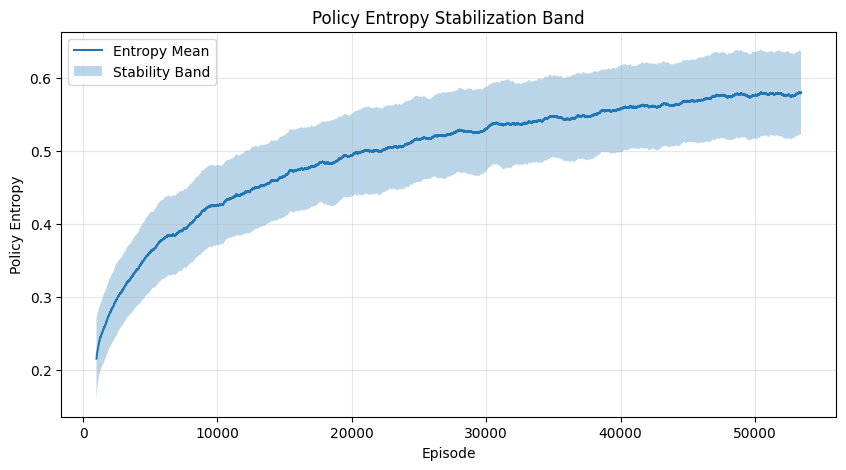

In [53]:
entropy = np.array(mc.entropy_history)

window = 1000
rolling_mean = np.convolve(entropy, np.ones(window)/window, mode='valid')

rolling_std = []
for i in range(len(rolling_mean)):
    segment = entropy[i:i+window]
    rolling_std.append(np.std(segment))

rolling_std = np.array(rolling_std)

upper = rolling_mean + rolling_std
lower = rolling_mean - rolling_std

x = np.arange(window-1, window-1+len(rolling_mean))

plt.figure(figsize=(10,5))
plt.plot(x, rolling_mean, label='Entropy Mean')
plt.fill_between(x, lower, upper, alpha=0.3, label='Stability Band')

plt.xlabel('Episode')
plt.ylabel('Policy Entropy')
plt.title('Policy Entropy Stabilization Band')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 🧠 Summary of Learnings - Convergence & Policy Behavior

The training process demonstrates convergence across three independent dimensions: performance, structure, and behavior.

**(1) Performance Convergence.**  
The moving average of cumulative reward plateaus after approximately $N$ episodes, indicating that additional training no longer yields meaningful performance improvement. This establishes that the agent has reached its maximal expected performance under the given reward structure.

**(2) Structural Convergence.**  
The growth of the Q-table slows and approaches a near-constant value. This indicates that the agent is no longer discovering new meaningful states, and that the internal representation of the environment has stabilized.

**(3) Behavioral Convergence.**  
Policy entropy initially increases as the agent learns to eliminate poor actions while preserving multiple viable strategies. After sufficient training, the entropy stabilizes within a narrow band, indicating consistent and stable decision-making. Importantly, this stabilized high entropy does not represent confusion. Instead, it reflects the agent’s recognition that multiple actions are equally optimal in many symmetric game states.

Such controlled uncertainty is a hallmark of strong decision policies in environments such as Tic-Tac-Toe, chess, and autonomous navigation, where maintaining flexibility among several optimal actions is preferable to rigid determinism.

**(4) Global Convergence Condition.**  
Convergence is confirmed when all three signals — reward, Q-table size, and policy entropy — simultaneously stabilize. When this condition is met, learning is complete: the agent’s performance, internal representation, and decision behavior no longer change in a statistically meaningful way.


# Game Play
using the Q table updated with MC

In [54]:
size = 3
game_over = True
game = TicTacToe(size)
# game.print_board_nums(game.size)
current_state = game.board.copy()

letter = mc.player_1
while game.empty_squares():
    moves = game.available_moves()
    if letter == mc.player_2:
        square = random.choice(moves)
        print(f"Player 2: {square}")
    else:
        state_str = mc.state_to_str(current_state)
        if state_str in mc.q_table.keys():
          filtered_items = [(key, value) for key, value in mc.q_table[state_str].items() if key in moves]
          square = max(filtered_items, key=lambda item: item[1])[0]
        else:
          square = random.choise(moves)
        print(f"Player 1: {square}")

    next_state = game.make_move(square, letter)
    game.print_board()
    print("__________________________________________________")

    if game.current_winner:
      print(f"Winner is {letter}.")
      game_over = False
      break

    letter = mc.player_2 if letter == mc.player_1 else mc.player_1  # Switch player
if game_over:
  print("its a Tie.")

Player 1: 2
|   |   | X |
|   |   |   |
|   |   |   |
__________________________________________________
Player 2: 5
|   |   | X |
|   |   | O |
|   |   |   |
__________________________________________________
Player 1: 8
|   |   | X |
|   |   | O |
|   |   | X |
__________________________________________________
Player 2: 0
| O |   | X |
|   |   | O |
|   |   | X |
__________________________________________________
Player 1: 7
| O |   | X |
|   |   | O |
|   | X | X |
__________________________________________________
Player 2: 6
| O |   | X |
|   |   | O |
| O | X | X |
__________________________________________________
Player 1: 3
| O |   | X |
| X |   | O |
| O | X | X |
__________________________________________________
Player 2: 4
| O |   | X |
| X | O | O |
| O | X | X |
__________________________________________________
Player 1: 1
| O | X | X |
| X | O | O |
| O | X | X |
__________________________________________________
its a Tie.


## -- Evaluate agent performance in games

In [55]:
def evaluate_agent(mc, games=5000):
    wins = 0
    losses = 0
    ties = 0

    for _ in range(games):
        game = TicTacToe(mc.size)
        state = game.board.copy()
        letter = mc.player_1

        while game.empty_squares():
            moves = game.available_moves()

            if letter == mc.player_2:
                square = random.choice(moves)
            else:
                state_str = mc.state_to_str(state)
                if state_str in mc.q_table:
                    filtered = [(a,v) for a,v in mc.q_table[state_str].items() if a in moves]
                    square = max(filtered, key=lambda x: x[1])[0]
                else:
                    square = random.choice(moves)

            state = game.make_move(square, letter)

            if game.current_winner:
                if letter == mc.player_1:
                    wins += 1
                else:
                    losses += 1
                break

            letter = mc.player_2 if letter == mc.player_1 else mc.player_1

        if not game.current_winner:
            ties += 1

    return wins, losses, ties

In [56]:
total_wins, total_losses, total_ties = evaluate_agent(mc, games=10000)


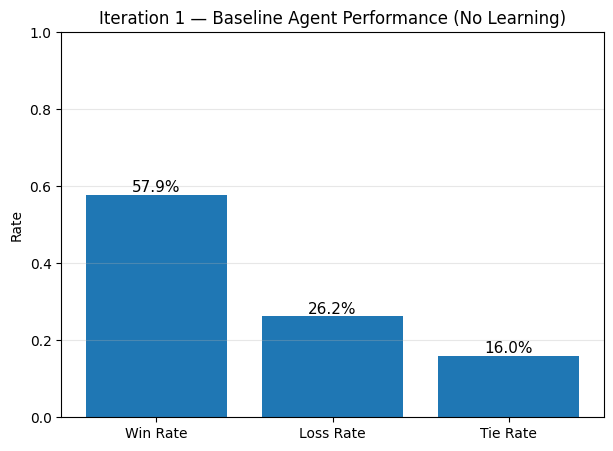

In [57]:
# -- Plot - Bar chart
import matplotlib.pyplot as plt

total_games = total_wins + total_losses + total_ties

win_rate  = total_wins   / total_games
loss_rate = total_losses / total_games
tie_rate  = total_ties   / total_games

labels = ['Win Rate', 'Loss Rate', 'Tie Rate']
rates  = [win_rate, loss_rate, tie_rate]

plt.figure(figsize=(7,5))
bars = plt.bar(labels, rates)

for bar, rate in zip(bars, rates):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f'{rate:.1%}',
             ha='center', va='bottom', fontsize=11)

plt.ylim(0, 1)
plt.ylabel('Rate')
plt.title('Iteration 1 — Baseline Agent Performance (No Learning)')
plt.grid(axis='y', alpha=0.3)
plt.show()


## -- Agent performance - Pie chart

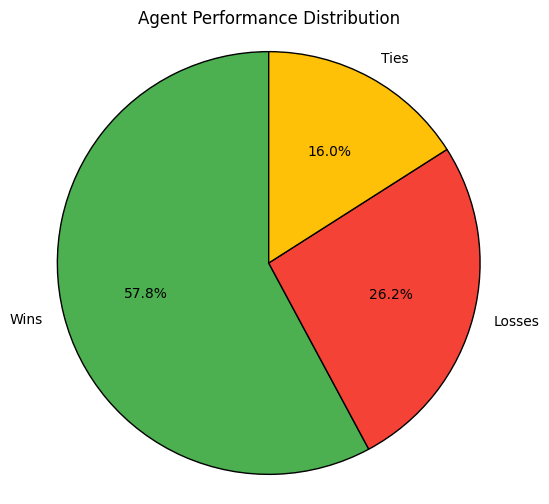

In [58]:
import matplotlib.pyplot as plt
import wandb

labels = ['Wins', 'Losses', 'Ties']
sizes  = [total_wins, total_losses, total_ties]
colors = ['#4CAF50', '#F44336', '#FFC107']

fig = plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=colors, wedgeprops={'edgecolor': 'black'})

plt.title('Agent Performance Distribution')
plt.axis('equal')  # keeps pie circular

# Log to W&B
wandb.log({"performance_pie": wandb.Image(fig)})

plt.show()
plt.close(fig)


# 2. Q Learning
Train your player using Q-learning. Update the Q-values using the Bellman equation.

Bellman eqution used to update the q values.

*Q(s, a) = Q(s, a) + &#945;[ r + &#947; max<sub>a`</sub>Q(s', a') - Q(s, a)]*

An Epsilon-Greedy strategy is employed to choose subsequent actions.

## Epsilon-Greedy Action Selection in Q-Learning
1. state_to_str(state): This function is designed to convert the game's state into a string, which serves as a dictionary key. It takes the state (likely a list or array) and concatenates all its elements into a single string. This string representation of the state is essential for storing and retrieving corresponding Q-values in the Q-table efficiently.
2. select_action(state, moves, epsilon): This function implements the epsilon-greedy policy to select the next action. It first converts the current state into a string using the state_to_str function. The action selection process then follows two paths based on a random number compared to the epsilon threshold:
Exploration: With a probability of epsilon, it selects a random action

  *   Exploration: With a probability of epsilon, it selects a random action from the list of available moves. This randomness introduces necessary exploration, allowing the algorithm to discover new strategies.
  * Exploitation: If the random number is above the epsilon threshold, the function proceeds to exploit known information. It checks if the state string exists in the Q-table. If not, a random action is chosen since no learned values exist. If the state is known, it filters the Q-table entries for that state to include only those actions that are available (moves). It then selects the action with the highest Q-value among these filtered entries, enabling the algorithm to use the best-known strategy based on past learning.

In [9]:
# Function to convert the state to a string for dictionary key
def state_to_str(state):
    return ''.join(state)

# Function to select action based on epsilon-greedy policy
def select_action(state, moves, epsilon):
    state_str = state_to_str(state)
    # Exploration: choose a random action with probability epsilon
    if np.random.rand() < epsilon:
        return random.choice(moves)
    else:
        # Exploitation: choose the action with the highest Q-value
        if state_str not in q_table:
            return random.choice(moves)
        filtered_items = [(key, value) for key, value in q_table[state_str].items() if key in moves]
        return max(filtered_items, key=lambda item: item[1])[0]

## 'update_q_table' function

In [10]:
# update Q-table
def update_q_table(state, action, reward, next_state, moves, learning_rate, discount_factor):
    state_str = state_to_str(state)
    next_state_str = state_to_str(next_state)

    # Initialize Q-values for new states
    if state_str not in q_table:
        q_table[state_str] = {action: 0 for action in game.total_moves()}

    if next_state_str not in q_table:
        q_table[next_state_str] = {action: 0 for action in game.total_moves()}

    # Compute max Q-value for next state
    max_next_q = max(q_table[next_state_str].values())

    # Q-learning update
    q_table[state_str][action] += learning_rate * (
        reward + discount_factor * max_next_q - q_table[state_str][action]
    )

#### 'train' function

In [9]:
def train(episodes, epsilon, epsilon_min, epsilon_decay):
    number_of_agent_actions, number_of_random_actions, game_result, epsilon_convergence = [], [], [], []
    # Iterate over the episodes
    for e in tqdm(range(episodes)):
        agent_action, random_action = 0, 0
        result = ''
        game = TicTacToe(size)
        current_state = game.board.copy()  # Copy the current state of the game

        letter = player_1  # Start with player 1
        # Keep playing until the game is over
        while game.empty_squares():
            moves = game.available_moves()  # Get available moves
            # Select a move for the current player
            if letter == player_2:
                random_action += 1
                square = random.choice(moves)  # Random move for player 2
            else:
                agent_action += 1
                square = select_action(current_state, moves, epsilon)  # Use Q-learning to select move for player 1

            next_state = game.make_move(square, letter)  # Make the move and get the next state

            # Check if there is a winner
            if game.current_winner:
                if letter == player_1:
                    reward = win_reward
                    result = 'win' # Player 1 wins
                else:
                    reward = lose_reward
                    result = 'loss'  # Player 2 wins
                break
            elif not game.empty_squares(): # If the game ends in a tie
              reward = tie_reward
              result = 'tie' # Tie reward
            else:
                reward = step_reward  # Small reward for continuing the game

            # Update the Q-table based on the current state, action, reward, and next state
            update_q_table(current_state, square, reward, next_state, moves, learning_rate, discount_factor)

            current_state = next_state.copy()  # Update the current state
            letter = player_2 if letter == player_1 else player_1  # Switch players
        epsilon_convergence.append(epsilon)
        if epsilon > epsilon_min:
          epsilon *= epsilon_decay
        number_of_agent_actions.append(agent_action)
        number_of_random_actions.append(random_action)
        game_result.append(result)
    return number_of_agent_actions, number_of_random_actions, game_result, epsilon_convergence

## Hyperparameters

In [11]:
size = 3 # define the size of grid for the game
learning_rate = 0.001 # (1) 1e-3, (2) 1e-1 - determining the weight of the new information
discount_factor = 0.9 # (1) 0.99, (2) 0.9, (3) 0.5 - balancing immediate and future reward
epsilon = 1 # balancing between exploration and exploitation for greedy strategy
episodes = 1000000 # (1) 1000000, (2) 10000000 - number of episode (games) to play for training
epsilon_decay = 0.999995  # (1) 0.995, (2) 0.999995 - Decay rate for epsilon
epsilon_min = 0.01

# === Rewards scores
win_reward  = 10 # (1) 1 - reward for the action the end up in winning
lose_reward = -10 # (1) 0 - reward for the action that end up in loss
tie_reward  = 1 # (1) 0 - reward for the action if it makes the game tie
step_reward = -0.01 # (1) 0.0001 - Small reward for continuing the game, actions that do not end up in win/lose/tie

import wandb

run = wandb.init(
    project="tictactoe-mc--q-learning",
    config={
        "size": size,
        "learning_rate": learning_rate,
        "discount_factor": discount_factor,
        "epsilon_start": epsilon,
        "epsilon_min": epsilon_min,
        "epsilon_decay": epsilon_decay,
        "win_reward": win_reward,
        "lose_reward": lose_reward,
        "tie_reward": tie_reward,
        "step_reward": step_reward,
        "episodes": episodes,
        "ma_window": 500,
    }
)
config = run.config


''' Q table to maintain the q values for state,actions
    {'state': {0: q-values, 1: q_values......n: q-value}}  '''
q_table = {}

player_1 = 'X' # Agent
player_2 = 'O' # Random Player
game = TicTacToe(size)

## Train the model

In [13]:
number_of_agent_actions, number_of_random_actions, episode_results, epsilon_convergence = train(episodes, epsilon, epsilon_min, epsilon_decay)

100%|██████████| 1000000/1000000 [00:40<00:00, 24921.00it/s]


In [15]:
print(f"Number of states after training in the Q table: {len(q_table.keys())}")

Number of states after training in the Q table: 4740


### Store trained Q table

In [14]:
path_to_store = my_path
file_name = "size_5_q_learning_table_" + str(episodes) + "ep.pkl"

with open(path_to_store+file_name, 'wb') as f:
        pickle.dump(q_table, f)

### Store train stats to CSV

In [16]:
import pandas as pd
store = pd.DataFrame({'#agent actions': number_of_agent_actions, '#computer actions': number_of_random_actions, 'epsilon': epsilon_convergence, 'result': episode_results})
store.to_csv(my_path+"q_learning_1000000ep.csv")

### Add to W&B run

In [17]:
# Add to W&B run
store = pd.DataFrame({
    "agent_actions": number_of_agent_actions,
    "computer_actions": number_of_random_actions,
    "epsilon": epsilon_convergence,
    "result": episode_results
})

# === 1. Log as interactive table ===
wandb.log({"episode_table": wandb.Table(dataframe=store)})

# === 2. Save and log as artifact (CSV file) ===
csv_path = "q_learning_1000000ep.csv"
store.to_csv(csv_path, index=False)

artifact = wandb.Artifact("q_learning_episode_data", type="dataset")
artifact.add_file(csv_path)
wandb.log_artifact(artifact)

# === 3. Log summary statistics ===
summary = store["result"].value_counts(normalize=True).to_dict()
wandb.run.summary["final_win_rate"]  = summary.get("win", 0)
wandb.run.summary["final_loss_rate"] = summary.get("loss", 0)
wandb.run.summary["final_tie_rate"]  = summary.get("tie", 0)

### Plot

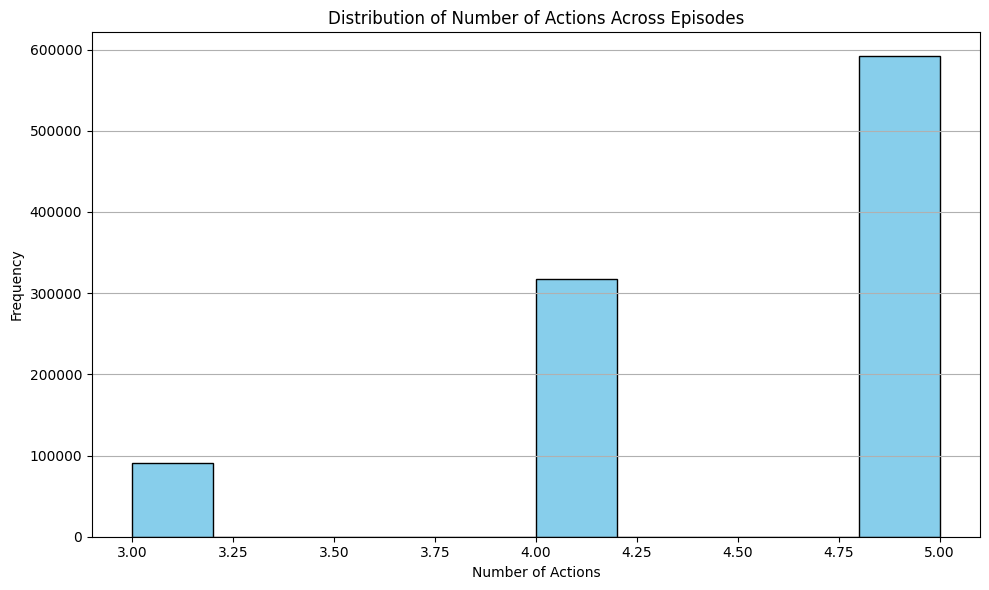

In [48]:
plt.figure(figsize=(10, 6))
plt.hist(number_of_agent_actions, bins=10, color='skyblue', edgecolor='black')  # Adjust bins as needed for the desired level of granularity

# Add labels and title
plt.xlabel('Number of Actions')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Actions Across Episodes')

# Show plot
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Game Play
Player 1 plays randomly and Player 2 chooses the action based on the Q table.

In [18]:
# if you want to use pre-trained Q table set it to True
pre_trained_q_table = False

if pre_trained_q_table:
  stored_path = my_path
  file_name = "size_5_q_learning_table_10000000ep.pkl"

  with open(stored_path + file_name, 'rb') as f:
        q_table = pickle.load(f)

number_of_games = 100 # number of games you want to play

''' Store the stats of the game play (for player 1: Agent)'''
total_wins, total_losses, total_ties = 0, 0, 0

for g in range(number_of_games):
  print(f"Game: {g}")

  game = TicTacToe(size)  # Initialize the game
  current_state = game.board.copy()

  letter = player_1  # Start with player 1
  while game.empty_squares():  # Continue playing until the board is full
      moves = game.available_moves()  # Get available moves
      if letter == player_2:
          # Player 2 (random player) selects a random move
          square = random.choice(moves)
          print(f"Player 2: {square}")
      else:
          state_str = state_to_str(current_state)
          # Player 1 (agent) selects the move with the highest Q-value based on the current state
          if state_str in q_table.keys():
              filtered_items = [(key, value) for key, value in q_table[state_str].items() if key in moves]
              square = max(filtered_items, key=lambda item: item[1])[0]
          else:
              square = random.choice(moves)  # If the state is not in Q-table, select a random move
          print(f"Player 1: {square}")

      next_state = game.make_move(square, letter)
      game.print_board()
      print("__________________________________________________")

      if game.current_winner:
        if letter == player_1:
          total_wins += 1
          print("Winner is the Agent.")
        else:
          total_losses += 1
          print("Winner is the Random Player")
        break
      elif not game.empty_squares():
        total_ties += 1
        print("It's a Tie.")

      letter = player_2 if letter == player_1 else player_1  # Switch players for the next move


Game: 0
Player 1: 0
| X |   |   |
|   |   |   |
|   |   |   |
__________________________________________________
Player 2: 5
| X |   |   |
|   |   | O |
|   |   |   |
__________________________________________________
Player 1: 1
| X | X |   |
|   |   | O |
|   |   |   |
__________________________________________________
Player 2: 6
| X | X |   |
|   |   | O |
| O |   |   |
__________________________________________________
Player 1: 2
| X | X | X |
|   |   | O |
| O |   |   |
__________________________________________________
Winner is the Agent.
Game: 1
Player 1: 0
| X |   |   |
|   |   |   |
|   |   |   |
__________________________________________________
Player 2: 1
| X | O |   |
|   |   |   |
|   |   |   |
__________________________________________________
Player 1: 2
| X | O | X |
|   |   |   |
|   |   |   |
__________________________________________________
Player 2: 4
| X | O | X |
|   | O |   |
|   |   |   |
__________________________________________________
Player 1: 3
| X | 

### Played Game Stats

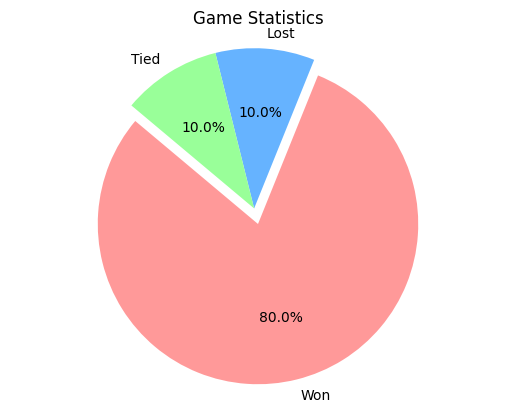

In [19]:
labels = ['Won', 'Lost', 'Tied']
sizes = [total_wins, total_losses, total_ties]
colors = ['#ff9999','#66b3ff','#99ff99']
explode = (0.1, 0, 0)  # explode 1st slice

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Game Statistics')

# === Log numeric totals ===
wandb.log({
    "total_wins": total_wins,
    "total_losses": total_losses,
    "total_ties": total_ties,
    "win_rate_final": total_wins / (total_wins + total_losses + total_ties),
    "loss_rate_final": total_losses / (total_wins + total_losses + total_ties),
    "tie_rate_final": total_ties / (total_wins + total_losses + total_ties)
})

# === Log the figure ===
wandb.log({"game_statistics_pie": wandb.Image(fig)})

plt.savefig(my_path +"game_stats_q_learning.jpg")
plt.show()

# Additional plots

## Win / Loss / Tie convergence

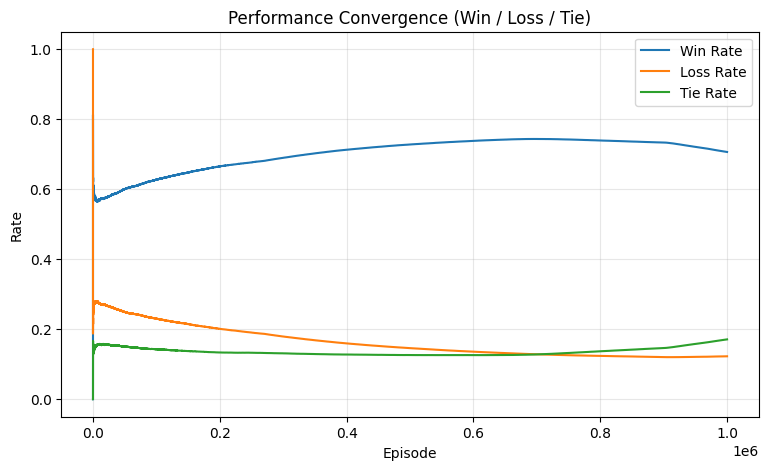

In [20]:
import numpy as np
import matplotlib.pyplot as plt

results = np.array(episode_results)

win_rate  = np.cumsum(results == 'win')  / np.arange(1, len(results)+1)
loss_rate = np.cumsum(results == 'loss') / np.arange(1, len(results)+1)
tie_rate  = np.cumsum(results == 'tie')  / np.arange(1, len(results)+1)

fig = plt.figure(figsize=(9,5))
plt.plot(win_rate, label='Win Rate')
plt.plot(loss_rate, label='Loss Rate')
plt.plot(tie_rate, label='Tie Rate')

plt.xlabel('Episode')
plt.ylabel('Rate')
plt.title('Performance Convergence (Win / Loss / Tie)')
plt.legend()
plt.grid(alpha=0.3)

# Log figure to W&B
wandb.log({"Performance Convergence (Win - Loss - Tie)": wandb.Image(fig)})

plt.show()


## Epsilon Decay & Policy Stabilization

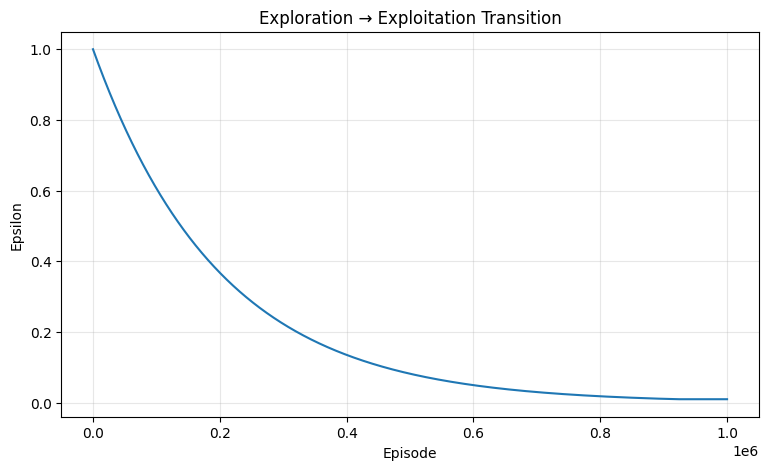

In [21]:
fig = plt.figure(figsize=(9,5))
plt.plot(epsilon_convergence)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Exploration → Exploitation Transition')
plt.grid(alpha=0.3)

# Log figure to W&B
wandb.log({"Exploration → Exploitation Transition": wandb.Image(fig)})

plt.show()


## Agent vs Random Action Dominance

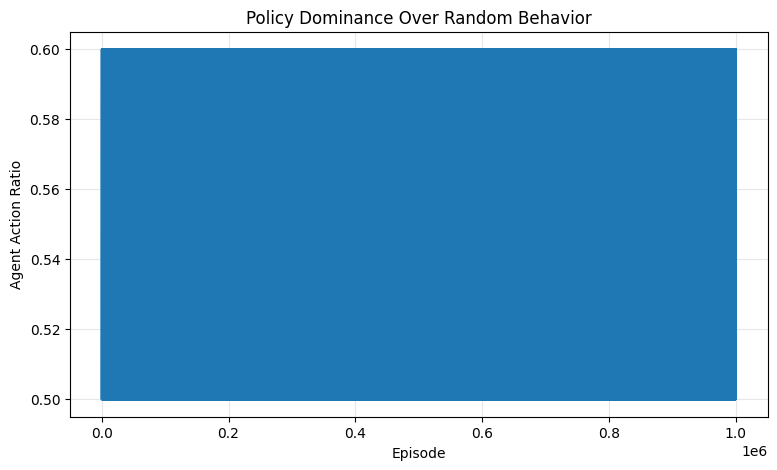

In [22]:
agent = np.array(number_of_agent_actions)
random_act = np.array(number_of_random_actions)

ratio = agent / (agent + random_act)

plt.figure(figsize=(9,5))
plt.plot(ratio)
plt.xlabel('Episode')
plt.ylabel('Agent Action Ratio')
plt.title('Policy Dominance Over Random Behavior')
plt.grid(alpha=0.3)
plt.show()


## Moving Window Performance Stability

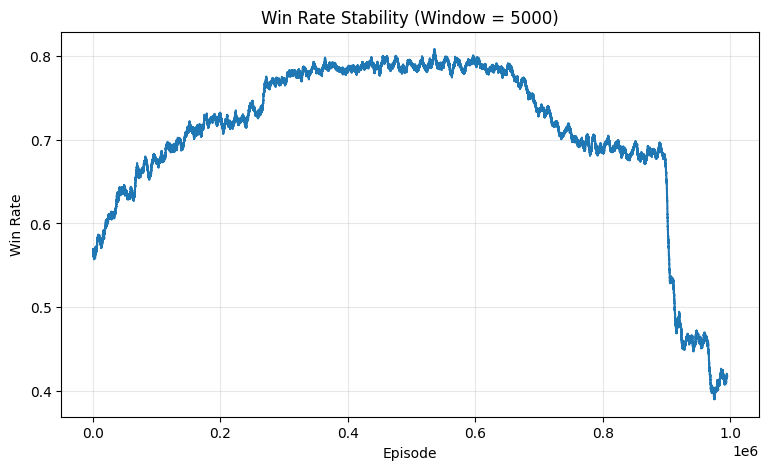

In [23]:
window = 5000
win_binary = (results == 'win').astype(int)

moving_win_rate = np.convolve(win_binary, np.ones(window)/window, mode='valid')

fig = plt.figure(figsize=(9,5))
plt.plot(moving_win_rate)
plt.xlabel('Episode')
plt.ylabel('Win Rate')
plt.title(f'Win Rate Stability (Window = {window})')
plt.grid(alpha=0.3)

# Log figure to W&B
wandb.log({f"Win Rate Stability (Window = {window})": wandb.Image(fig)})

plt.show()


# 3. DQN & DDQN
## DQN (Deep Q-Network):
* In DQN, a target network is employed to determine the best action for the next state from the current state during the game. This separate model, the target network, mirrors the architecture of the main network but with periodically updated weights.
* Once the best action is selected by the target network, its Q-value is estimated using the same target network, not the main network. This approach aims to stabilize training by reducing the frequency of policy changes, as the target network's weights are updated less often than those of the main network.
* However, using the same network to both select and evaluate an action can sometimes lead to overestimations of Q-values. This is due to positive biases inherent in the bootstrapping methods where the maximum estimated returns are used for updates. In a game context, such overestimations can lead the learning process to favor certain strategies that might not be as effective as predicted, potentially affecting overall strategy development in gameplay.

## DDQN (Double Deep Q-Network):

* DDQN modifies the DQN approach by splitting the role of action selection and Q-value estimation between two networks. In this setup, the main network is used to choose the best action from the next state.
* However, unlike DQN, the Q-value of this action is evaluated using the target network. This cross-evaluation helps in mitigating the overestimation issue seen in DQN.
* By decoupling the selection and evaluation of actions, DDQN provides a more conservative estimate of Q-values, enhancing the accuracy and stability of training. In the context of Tic Tac Toe, this means DDQN can more reliably evaluate the potential future benefits of moves, leading to more strategic decision-making and potentially stronger gameplay over time.

In [12]:
from tensorflow.keras.optimizers import Adam

class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=32):
        self.state_size = state_size  # Size of the state space
        self.action_size = action_size  # Number of possible actions
        self.learning_rate = learning_rate  # Learning rate for the neural network
        self.gamma = gamma  # Discount factor for future rewards
        self.epsilon = epsilon  # Exploration rate for epsilon-greedy strategy
        self.epsilon_decay = epsilon_decay  # Decay rate for epsilon
        self.epsilon_min = epsilon_min  # Minimum exploration rate
        self.batch_size = batch_size  # Batch size for training
        self.model = self._build_model()  # Initialize the neural network model
        self.target_model = self._build_model()  # Initialize the target model for fixed Q-targets
        self.replay_memory = deque(maxlen=2000)  # Initialize replay memory

    def _build_model(self):
        model = Sequential()

        # Input layer
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))

        # Hidden layers
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))

        # Output layer: one Q-value per action
        model.add(Dense(self.action_size, activation='linear'))

        model.compile(
            optimizer=Adam(learning_rate=self.learning_rate),
            loss='mse'
        )

        return model

    def act(self, state, moves):
        # Choose an action based on epsilon-greedy strategy
        if np.random.rand() <= self.epsilon:
            return random.choice(moves)  # Explore: choose a random action
        q_values = self.model.predict(state, verbose=None)  # Exploit: choose the action with highest Q-value
        valid_move_indices = [(i, q_values[0][i]) for i in moves]
        max_valid_move_index, _ = max(valid_move_indices, key=lambda x: x[1])
        return max_valid_move_index

    def remember(self, state, action, reward, next_state, done):
        # Store the experience in replay memory
        self.replay_memory.append((state, action, reward, next_state, done))

    def replay(self, episode, algorithm='DQN'):
        # Train the neural network using experience replay
        if len(self.replay_memory) < self.batch_size:
            return

        minibatch = random.sample(self.replay_memory, self.batch_size)  # Sample a minibatch from replay memory

        states, targets = [], []
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                # Calculate the target value for the Bellman equation
                if algorithm == 'DQN':
                    target = reward + self.gamma * np.amax(self.target_model.predict(next_state, verbose=None)[0])
                else:  # Double DQN (DDQN)
                    next_action = np.argmax(self.model.predict(next_state, verbose=None)[0])
                    target = reward + self.gamma * self.target_model.predict(next_state, verbose=None)[0][next_action]
            target_f = self.model.predict(state, verbose=None)
            target_f[0][action] = target
            states.append(state[0])
            targets.append(target_f[0])

        # Train the model on the minibatch
        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

        # Update the target model periodically
        if episode % 10 == 0:
            self.update_target_model()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return self.epsilon

    def update_target_model(self):
        # Update the weights of the target model to match the current model
        self.target_model.set_weights(self.model.get_weights())

## Hyperparamters

In [14]:
REWARDS = {'win': 1, 'lose': -10, 'tie': 0.5, 'step': 0.002}
NUM_EPISODES = 100
size = 3  # Assuming a 3x3 tic-tac-toe board
state_size = size * size  # Number of cells on the game board
action_size = state_size  # Number of possible actions, total cells on the game board
learning_rate = 0.01 # Learning rate for the agent
gamma = 0.95 # Discount factor for future rewards
epsilon = 1 # Initial value of epsilon for epsilon-greedy exploration
epsilon_decay = 0.995  # Decay rate for epsilon
epsilon_min = 0.01 # Minimum value of epsilon to ensure some level of exploration
batch_size = 32
algorithm = 'DQN' # choose 'DQN or 'DDQN'
player_1 = 'X'
player_2 = 'O'

#### Training the DQN model

In [13]:
agent = DQNAgent(state_size, action_size)

def reshape_state(state): # [[0,1,0,0,0,0,-1,0,0]] for model
  reshaped_state = [0 if cell == ' ' else 1 if cell == 'X' else -1 for cell in state]
  reshaped_state = np.array(reshaped_state)
  return reshaped_state

# Loop through episodes for training
number_of_agent_actions, number_of_random_actions, episode_results, epsilon_convergence = [], [], [], []
for episode in tqdm(range(NUM_EPISODES)):
    game = TicTacToe(size)  # Initialize the TicTacToe game
    done = False  # Indicates if terminal state is reached
    current_state = game.board.copy()  # Copy the initial state of the board
    letter = player_1  # Set the mark for the first player (player 1)
    agent_actions, random_actions = 0, 0
    result = ''
    while game.empty_squares():  # While there are empty squares on the board
        reshaped_current_state = reshape_state(current_state)  # Reshape the state representation
        reshaped_current_state = reshaped_current_state.reshape(1, -1)  # Reshape for compatibility with the model
        moves = game.available_moves()  # Get available moves

        if letter == player_2:  # If it's player 2's turn
            random_actions += 1
            square = random.choice(moves)  # Choose a random move
        else:
            agent_actions += 1
            square = agent.act(reshaped_current_state, moves)  # Choose a move using the agent
            # print(square)

        next_state = game.make_move(square, letter)  # Make the chosen move and get the next state
        reshaped_next_state = reshape_state(next_state)  # Reshape the next state
        reshaped_next_state = reshaped_next_state.reshape(1, -1)  # Reshape for compatibility with the model
        # print(reshaped_next_state)
        # print("-----------------------------------------------------------------------")

        if game.current_winner:  # If there is a winner
            if letter == player_1:  # If player 1 wins
                reward = REWARDS['win']
                result = 'win'  # Assign win reward
            else:
                result = 'loss'
                reward = REWARDS['lose']  # Assign lose reward
            done = True  # Mark episode as done
        else:
            reward = REWARDS['step']  # Assign step reward
            last_state = reshaped_current_state  # Store the last state

        # Store the experience tuple (state, action, reward, next_state, done) in the agent's memory
        agent.remember(reshaped_current_state, square, reward, reshaped_next_state, done)

        # Replay experience to train the agent
        epsilon = agent.replay(episode, 'DQN')

        current_state = next_state.copy()  # Update the current state
        letter = player_2 if letter == player_1 else player_1  # Switch player

    if not done:  # If the episode was not terminated (tied)
        result = 'tie'
        reward = REWARDS['tie']  # Assign tie reward
        agent.remember(last_state, square, reward, reshaped_next_state, done)  # Store the last state
        agent.replay(episode, 'DQN')  # Log the last state that was a tie
    epsilon_convergence.append(epsilon)
    episode_results.append(result)
    number_of_agent_actions.append(agent_actions)
    number_of_random_actions.append(random_actions)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
  3%|▎         | 3/100 [00:10<05:45,  3.56s/it]


KeyboardInterrupt: 

#### save the DQN model

In [11]:
# @title
# target model is updated after every 10 episodes, weight from the 'model' is copied to target_model
path_to_store = my_path
model_name = "ddqn_" + str(NUM_EPISODES) + "ep.h5"
agent.target_model.save(path_to_store + model_name) # change the path for your prefered location

### storing game states in csv

In [12]:
import pandas as pd
store = pd.DataFrame({'#agent actions': number_of_agent_actions, '#computer actions': number_of_random_actions, 'result': episode_results})
store.to_csv(my_path+"dqn__10ep.csv")

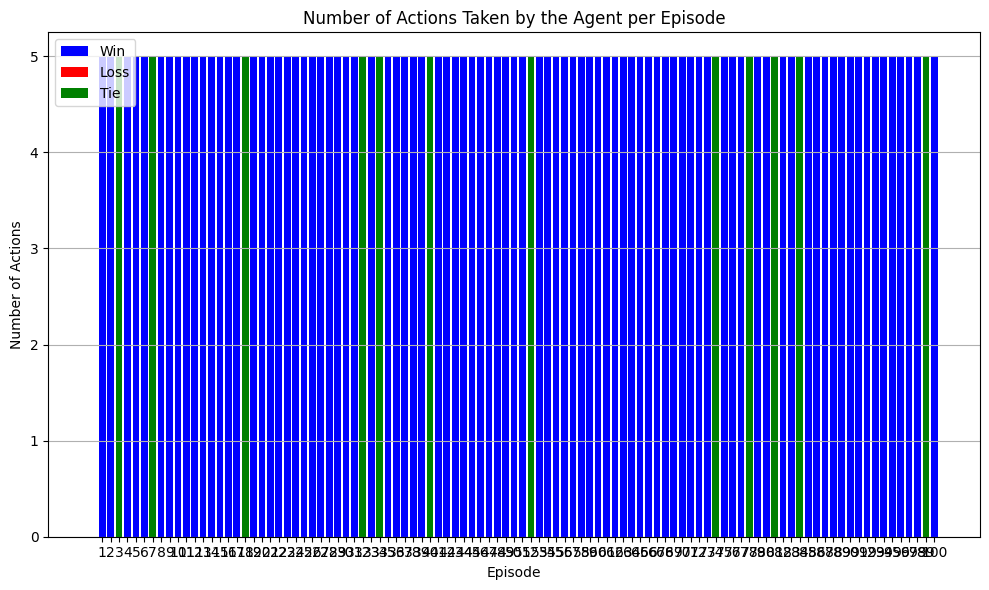

In [13]:
import matplotlib.pyplot as plt

# Mapping status to color
status_color_map = {'win': 'blue', 'loss': 'red', 'tie': 'green'}

# Plotting the bar graph
plt.figure(figsize=(10, 6))
for i in range(len(number_of_agent_actions)):
    plt.bar(i + 1, number_of_agent_actions[i], color=status_color_map[episode_results[i]])

# Adding labels and title
plt.xlabel('Episode')
plt.ylabel('Number of Actions')
plt.title('Number of Actions Taken by the Agent per Episode')

# Adding legend for status colors
for status, color in status_color_map.items():
    plt.bar(0, 0, color=color, label=status.capitalize())  # Dummy bar for legend
plt.legend()

# Show plot
plt.grid(axis='y')
plt.xticks(range(1, len(number_of_agent_actions) + 1))
plt.tight_layout()
plt.savefig(my_path+"dqn_train_stat.jpg")
plt.show()

#### Game Play with DQN or DDQN model

In [15]:
from tensorflow.keras.losses import MeanSquaredError

use_pre_trained_model = True

if use_pre_trained_model:
  stored_path = my_path
  model_name = "ddqn_" + str(NUM_EPISODES) + "ep.h5"
  model = load_model(
    stored_path + model_name,
    custom_objects={'mse': MeanSquaredError()}
  )

number_of_games = 10 # number of games you want to play

''' Store the stats of the game play (for player 1: Agent)'''
total_wins, total_losses, total_ties = 0, 0, 0

for g in range(number_of_games):
  print(f"Game: {g}")
  game = TicTacToe(size)
  current_state = game.board.copy()
  letter = player_1
  done = False
  while game.empty_squares():
    reshaped_current_state = reshape_state(current_state) # reshaping to (3,3), ' '->0, 'X'->1, 'O'->-1
    reshaped_current_state = reshaped_current_state.reshape(1, -1)
    moves = game.available_moves()
    if letter == player_1:
      print(f"Player 2: {square}")
      square = random.choice(moves)
    else:
      print(f"Player 1: {square}")
      q_values = model.predict(reshaped_current_state, verbose=None)
      valid_move_indices = [(i, q_values[0][i]) for i in moves]
      square, max_valid_move_value = max(valid_move_indices, key=lambda x: x[1])
    next_state = game.make_move(square, letter)
    game.print_board()
    print("________________________________________________________________________")
    if game.current_winner:
        if letter == player_1:
          total_wins += 1
          print("Winner is the Agent.")
        else:
          total_losses += 1
          print("Winner is the Random Player")
        break
    elif not game.empty_squares():
        total_ties += 1
        print("It's a Tie.")
    letter = player_2 if letter == player_1 else player_1  # Switch player


Game: 0
Player 2: 1
|   | X |   |
|   |   |   |
|   |   |   |
________________________________________________________________________
Player 1: 1
|   | X |   |
|   |   | O |
|   |   |   |
________________________________________________________________________
Player 2: 5
|   | X |   |
| X |   | O |
|   |   |   |
________________________________________________________________________
Player 1: 3
| O | X |   |
| X |   | O |
|   |   |   |
________________________________________________________________________
Player 2: 0
| O | X | X |
| X |   | O |
|   |   |   |
________________________________________________________________________
Player 1: 2
| O | X | X |
| X |   | O |
| O |   |   |
________________________________________________________________________
Player 2: 6
| O | X | X |
| X |   | O |
| O |   | X |
________________________________________________________________________
Player 1: 8
| O | X | X |
| X |   | O |
| O | O | X |
_________________________________________________

### Plotting game play states

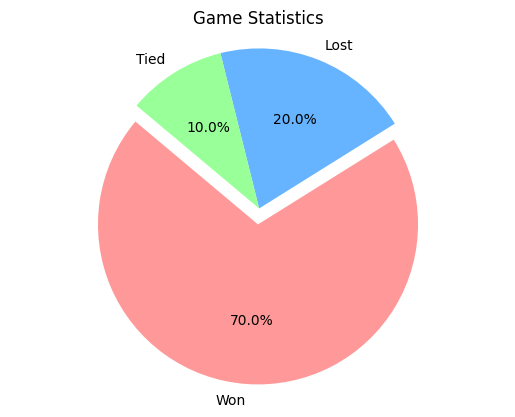

In [16]:
labels = ['Won', 'Lost', 'Tied']
sizes = [total_wins, total_losses, total_ties]
colors = ['#ff9999','#66b3ff','#99ff99']
explode = (0.1, 0, 0)  # explode 1st slice

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Game Statistics')
plt.show()